# Hamming weight extractor

- Extracts the Hamming weight of the state after the SBox in the first round.
- Appends a hamming weight column to the ASCAD file.

In [1]:
import os

import numpy as np
import seaborn as sns

from src.data.loaders.ascad import ASCADData
from src.data.preprocess.hw import full_states
from src.pollution.jitter import jitter
from src.tools.plotter import init_plots
from src.trace_set.ascad import TraceSet, Database, Pollution, PollutionType

init_plots()

In [2]:
ascad = ASCADData.random_key()
plaintext_ix = 0
full_key_ix = 1

profile_metadata = np.array(ascad["Profiling_traces"]["metadata"])
profile_traces = np.array(ascad["Profiling_traces"]["traces"])

attack_metadata = np.array(ascad["Attack_traces"]["metadata"])
attack_traces = np.array(ascad["Attack_traces"]["traces"])

def get_acc(metadata):
    return np.zeros((len(metadata), 16), dtype=np.uint8)

profile_key, profile_plain = get_acc(profile_metadata), get_acc(profile_metadata)
attack_key, attack_plain = get_acc(attack_metadata), get_acc(attack_metadata)

for ix in range(len(profile_metadata)):
    profile_key[ix] = profile_metadata[ix][full_key_ix]
    profile_plain[ix] = profile_metadata[ix][plaintext_ix]

for ix in range(len(attack_metadata)):
    attack_key[ix] = attack_metadata[ix][full_key_ix]
    attack_plain[ix] = attack_metadata[ix][plaintext_ix]

ascad.close()

### Calculate full intermediate states from AES

Based on plaintext and key metadata.

In [3]:
profile_hw = full_states(profile_plain, profile_key)
attack_hw = full_states(attack_plain, attack_key)

100%|██████████| 100000/100000 [00:29<00:00, 3360.02it/s]


### Hamming Weights of the first byte of the first state.

In [4]:
profile_hw_00 = profile_hw[:, 0, 0]
attack_hw_00 = attack_hw[:, 0, 0]

<AxesSubplot:>

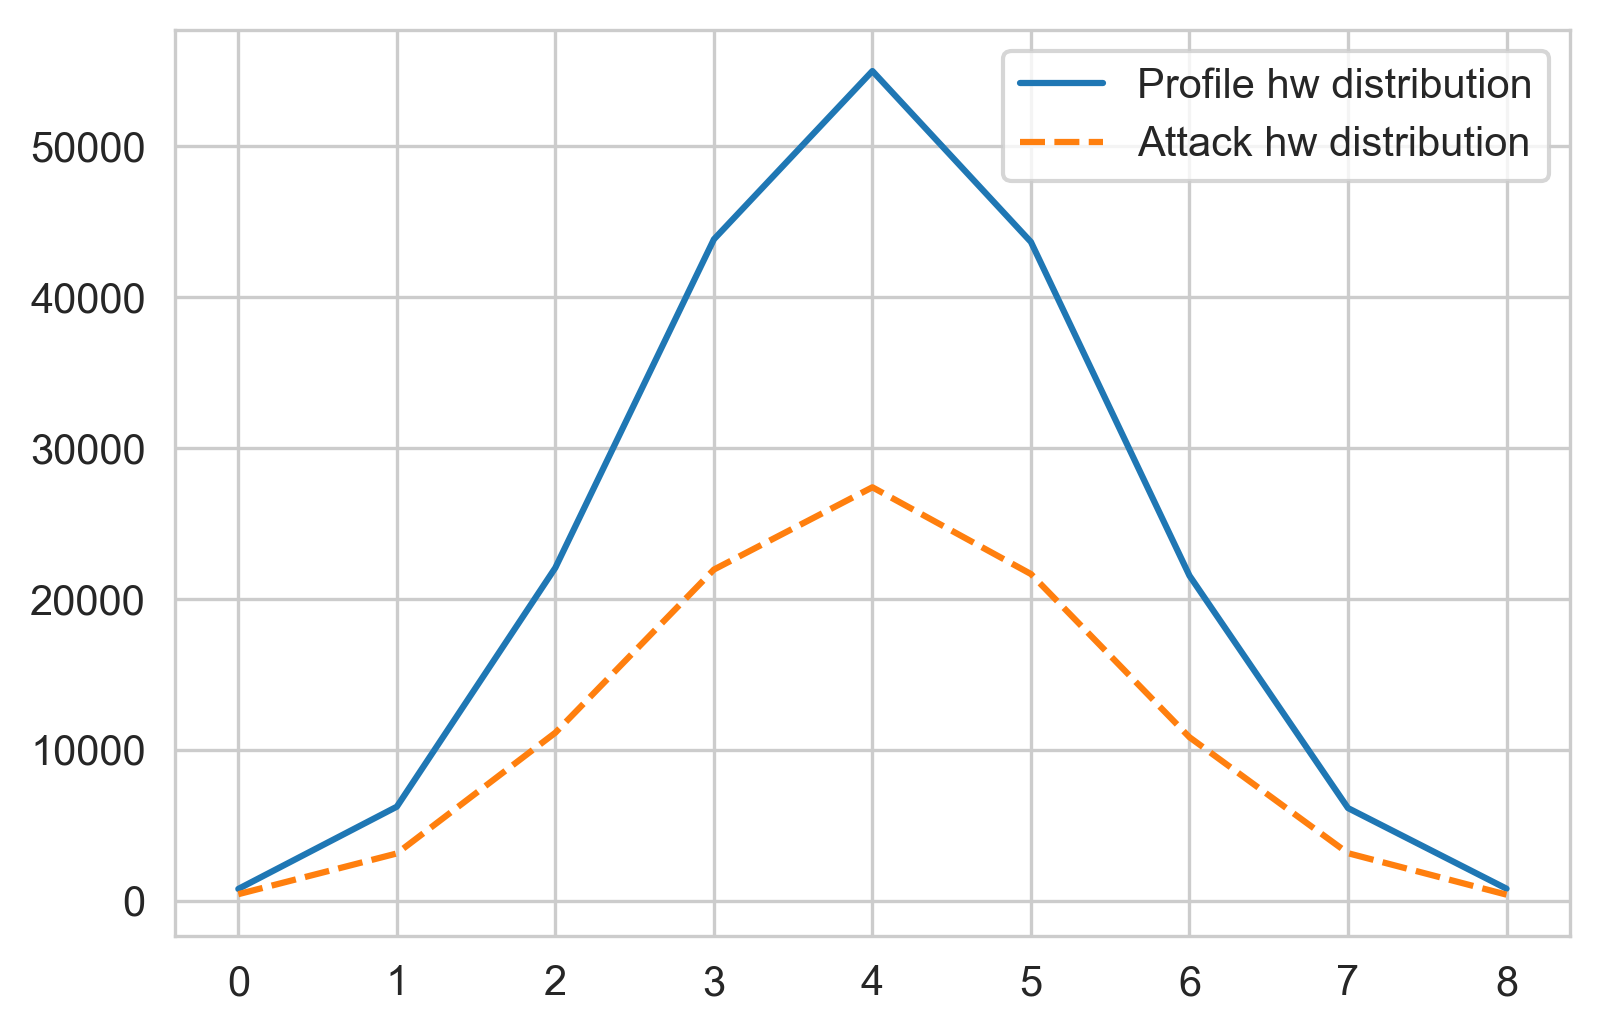

In [5]:
sns.lineplot(data={
    "Profile hw distribution": np.bincount(profile_hw_00),
    "Attack hw distribution": np.bincount(attack_hw_00),
})

In [6]:
OUT = TraceSet(Database.ascad)

if not os.path.exists(os.path.dirname(OUT.path)):
    os.makedirs(os.path.dirname(OUT.path))

OUT.open("w")

OUT.add({
    "profile": {
        "traces": profile_traces,
        "hw": profile_hw_00
    },
    "attack": {
        "traces": attack_traces,
        "hw": attack_hw_00
    }
})

OUT.close()


In [7]:
JITTER_PARAMS = np.arange(.75, 10.25, .25)

for param in JITTER_PARAMS:
    pollution = Pollution(PollutionType.jitter, param)
    out = TraceSet(Database.ascad, pollution)

    if not os.path.exists(out.path):
        profile_jitter = jitter(profile_traces, param)
        attack_jitter = jitter(attack_traces, param)

        out.open("w")

        out.add({
            "profile": {
                "traces": profile_jitter,
                "hw": profile_hw_00
            },
            "attack": {
                "traces": attack_jitter,
                "hw": attack_hw_00
            }
        })

        out.close()

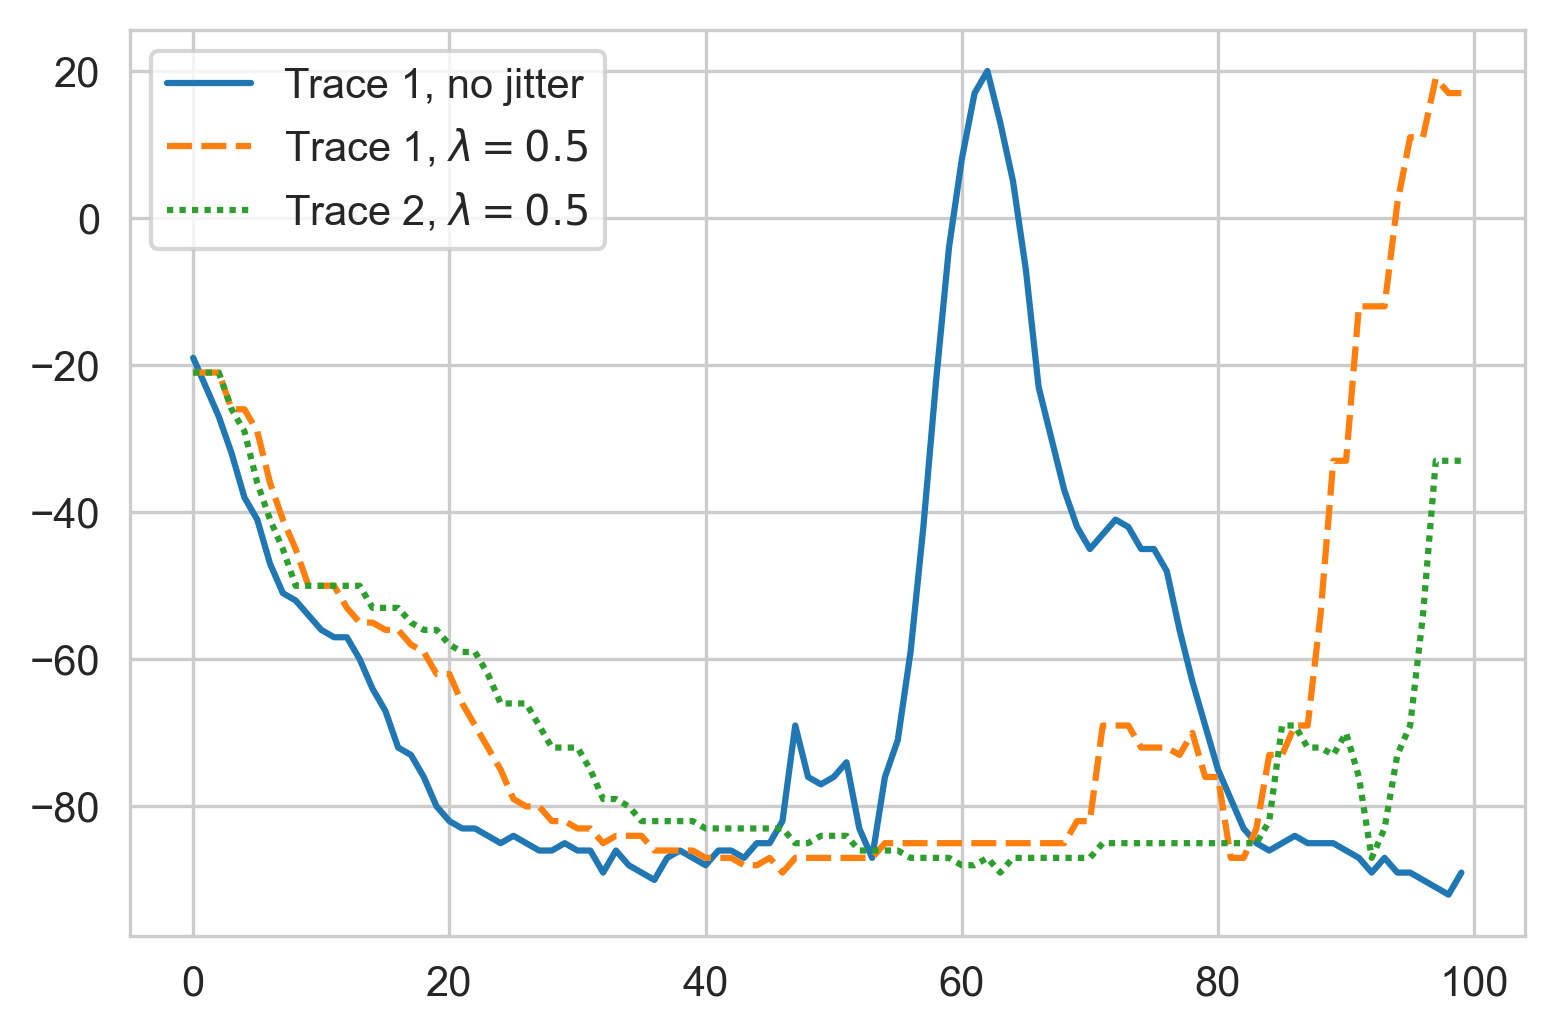

In [10]:
EXAMPLE = TraceSet(Database.ascad, Pollution(PollutionType.jitter, 1))
f = EXAMPLE.open('r')

sns.lineplot(data={
    "Trace 1, no jitter": profile_traces[0, :100],
    "Trace 1, $\lambda = 0.5$": np.array(f["profile"]["traces"])[0, :100],
    "Trace 2, $\lambda = 0.5$": np.array(f["profile"]["traces"])[1, :100],
})

EXAMPLE.close()